In [1]:
!pip install easyocr transformers torch nltk pandas pillow



[notice] A new release of pip is available: 23.2.1 -> 26.0.1
[notice] To update, run: C:\Users\Admin\AppData\Local\Programs\Python\Python312\python.exe -m pip install --upgrade pip


In [2]:
# Basic
import re

# Data handling
import pandas as pd

# Image handling
from PIL import Image

# OCR
import easyocr

# NLP
import nltk
from nltk.corpus import stopwords

# Deep Learning
import torch

# BERT (Transformers)
from transformers import BertTokenizer, BertModel


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


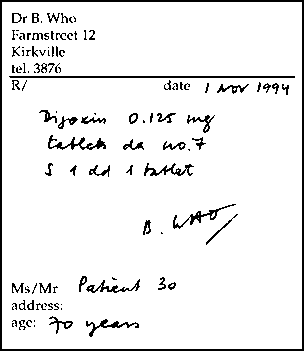

In [4]:
image_path = "../data/1.jpg"   # your prescription image
img = Image.open(image_path)
img


In [5]:
reader = easyocr.Reader(['en'], gpu=False)

ocr_result = reader.readtext(image_path)

ocr_text = " ".join([text for (_, text, _) in ocr_result])

print("Extracted Text from Prescription Image:")
print(ocr_text)


Using CPU. Note: This module is much faster with a GPU.
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Extracted Text from Prescription Image:
Dr B;, Who Farmstrcct 12 Kirkvillc tel, 3876 uate Lav 1994 ttriw 0.12 m% theoh ~ M0,7 44 hlt Lm Ms/Mr Pehuiof 30 address; 7v Ye+ Agc:


In [6]:
doctor_notes = [
    "Avoid oily and fried food",
    "Reduce sugar intake",
    "Limit salt consumption",
    "Increase intake of green vegetables",
    "Drink plenty of water daily",
    "Avoid junk food and soft drinks",
    "Include fruits in daily diet",
    "Reduce consumption of processed food"
]

df = pd.DataFrame({"doctor_notes": doctor_notes})
df


,doctor_notes
0,Avoid oily and fried food
1,Reduce sugar intake
2,Limit salt consumption
3,Increase intake of green vegetables
4,Drink plenty of water daily
5,Avoid junk food and soft drinks
6,Include fruits in daily diet
7,Reduce consumption of processed food


In [7]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    words = text.split()
    words = [w for w in words if w not in stop_words]
    return " ".join(words)

df["clean_text"] = df["doctor_notes"].apply(clean_text)
df


,doctor_notes,clean_text
0,Avoid oily and fried food,avoid oily fried food
1,Reduce sugar intake,reduce sugar intake
2,Limit salt consumption,limit salt consumption
3,Increase intake of green vegetables,increase intake green vegetables
4,Drink plenty of water daily,drink plenty water daily
5,Avoid junk food and soft drinks,avoid junk food soft drinks
6,Include fruits in daily diet,include fruits daily diet
7,Reduce consumption of processed food,reduce consumption processed food


In [8]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased")


Loading weights: 100%|██████████| 199/199 [00:00<00:00, 321.34it/s, Materializing param=pooler.dense.weight]                               
BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.bias                       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [9]:
def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1)

df["bert_embedding"] = df["clean_text"].apply(get_bert_embedding)


In [10]:
instruction_keywords = ["avoid", "reduce", "limit", "increase", "drink", "include"]

def is_instruction(text):
    return any(word in text for word in instruction_keywords)

df["is_instruction"] = df["clean_text"].apply(is_instruction)
df


,doctor_notes,clean_text,bert_embedding,is_instruction
0,Avoid oily and fried food,avoid oily fried food,"[[tensor(0.0085), tensor(0.1498), tensor(-0.23...",True
1,Reduce sugar intake,reduce sugar intake,"[[tensor(-0.0826), tensor(0.1897), tensor(-0.2...",True
2,Limit salt consumption,limit salt consumption,"[[tensor(0.0437), tensor(0.3273), tensor(-0.44...",True
3,Increase intake of green vegetables,increase intake green vegetables,"[[tensor(0.0431), tensor(0.2094), tensor(0.055...",True
4,Drink plenty of water daily,drink plenty water daily,"[[tensor(0.1253), tensor(0.1034), tensor(-0.00...",True
5,Avoid junk food and soft drinks,avoid junk food soft drinks,"[[tensor(0.1947), tensor(0.2699), tensor(-0.17...",True
6,Include fruits in daily diet,include fruits daily diet,"[[tensor(-0.0193), tensor(0.1749), tensor(-0.0...",True
7,Reduce consumption of processed food,reduce consumption processed food,"[[tensor(0.1063), tensor(0.1698), tensor(-0.13...",True


In [11]:
def map_to_diet_rules(text):
    rules = []

    if "oily" in text or "fried" in text:
        rules.append("Avoid fried and oily foods")
    if "sugar" in text:
        rules.append("Low sugar diet")
    if "salt" in text:
        rules.append("Low sodium diet")
    if "vegetable" in text or "fruit" in text:
        rules.append("High fiber diet")
    if "water" in text:
        rules.append("Increase water intake")
    if "junk" in text or "soft" in text:
        rules.append("Avoid junk food and soft drinks")

    return rules

df["diet_rules"] = df["clean_text"].apply(map_to_diet_rules)
df


,doctor_notes,clean_text,bert_embedding,is_instruction,diet_rules
0,Avoid oily and fried food,avoid oily fried food,"[[tensor(0.0085), tensor(0.1498), tensor(-0.23...",True,[Avoid fried and oily foods]
1,Reduce sugar intake,reduce sugar intake,"[[tensor(-0.0826), tensor(0.1897), tensor(-0.2...",True,[Low sugar diet]
2,Limit salt consumption,limit salt consumption,"[[tensor(0.0437), tensor(0.3273), tensor(-0.44...",True,[Low sodium diet]
3,Increase intake of green vegetables,increase intake green vegetables,"[[tensor(0.0431), tensor(0.2094), tensor(0.055...",True,[High fiber diet]
4,Drink plenty of water daily,drink plenty water daily,"[[tensor(0.1253), tensor(0.1034), tensor(-0.00...",True,[Increase water intake]
5,Avoid junk food and soft drinks,avoid junk food soft drinks,"[[tensor(0.1947), tensor(0.2699), tensor(-0.17...",True,[Avoid junk food and soft drinks]
6,Include fruits in daily diet,include fruits daily diet,"[[tensor(-0.0193), tensor(0.1749), tensor(-0.0...",True,[High fiber diet]
7,Reduce consumption of processed food,reduce consumption processed food,"[[tensor(0.1063), tensor(0.1698), tensor(-0.13...",True,[]


In [12]:
total_notes = len(df)
converted_notes = df["diet_rules"].apply(len).gt(0).sum()

conversion_rate = (converted_notes / total_notes) * 100
conversion_rate


np.float64(87.5)

In [13]:
print("Final Actionable Diet Recommendations:\n")

for rules in df["diet_rules"]:
    for rule in rules:
        print("-", rule)


Final Actionable Diet Recommendations:

- Avoid fried and oily foods
- Low sugar diet
- Low sodium diet
- High fiber diet
- Increase water intake
- Avoid junk food and soft drinks
- High fiber diet
